https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline 

import utility.utility as ut
from preprocessing.createSets import *
from preprocessing.Sets import Sets
from utility.ML import ML

In [2]:
########### switches ################################

saveName='Oct21-2018_4'
saveFolder = saveName
saveplots=False
createSubmit = True
if not os.path.exists(saveFolder) and (saveplots or createSubmit): 
    print 'creating folder:',os.getcwd()+'/'+saveFolder
    os.mkdir(saveFolder)
if(saveplots): print "SAVING PLOTS!"
if(createSubmit): print "WILL CREATE SUBMIT FILE!"

############# Options/Args #########################

verbose=True
lag_length = 5
diff = True
diffRel = False 
addPriceRange = True

target = 'shop_item_cnt_month'
# target = 'shop_item_cnt_month_diff(0-1)'

#these columns will be dropped in createTrain/Val/Test --> Depracated
col_targets=[]

####### mean Encode (with Reg) #####

meanEncode=True #this is just necessary condition for mean encoding. but need to turn on individual switches below to include columsn of target encoding.
meanEncodeCol=[ #this is for lag features.
             'shop',
             'item',
             'item_cat',
            ]

agg_targ = {'item_cnt_day':'sum'} #target_encoding!
# agg_targ = {'item_cnt_day':'mean'} #target_encoding!

Regularize = True
enc_cnt_per_shop = True
enc_cnt_per_item = True
enc_cnt_per_item_cat = True
enc_priceRange = True

targEnc_to_Reg = {}
NaN_targEnc = {}

if(enc_cnt_per_shop):targEnc_to_Reg.update({'shop_id':'shop'})
if(enc_cnt_per_item):targEnc_to_Reg.update({'item_id':'item'})
if(enc_cnt_per_item_cat):targEnc_to_Reg.update({'item_category_id':'item_cat'})
if(enc_priceRange):targEnc_to_Reg.update({'price_range':'price_range'})

if(enc_cnt_per_shop):NaN_targEnc.update({'shop':-999})
if(enc_cnt_per_item):NaN_targEnc.update({'item':-999})
if(enc_cnt_per_item_cat):NaN_targEnc.update({'item_cat':-999})
if(enc_priceRange):NaN_targEnc.update({'price_range':-999})

####################################

#columns to keep
col_to_keep = [
                'shop_id',
                'item_id',
                #'item_price',
                'item_category_id',
                'item_cnt_day',
                ]

groupby_list = ['shop_id','item_id']

agg_dict = {
            #'item_price':'mean',
            'item_category_id':'mean',
            'item_cnt_day':'sum',
            }

    
opt = {
        'verbose':verbose,
        'lag_length':lag_length,
        'diff':diff,
        'diffRel':diffRel,
        'target':target,
        'col_to_keep':col_to_keep,
        'groupby_list':groupby_list,
        'agg_dict':agg_dict,
        'agg_targ':agg_targ,
        'col_targets':col_targets,
        'meanEncode':meanEncode,
        'meanEncodeCol':meanEncodeCol,
        'targEnc_to_Reg':targEnc_to_Reg,
        'NaN_targEnc':NaN_targEnc,
        } 


#clipTarget = True
lowerClip = 0
upperClip = 20
if target=='shop_item_cnt_month_diff(0-1)':
    lowerClip = -20
    upperClip = 20    

########################################################

creating folder: /Users/rizki/Dropbox/Coursera/AML_HowToKaggle/FinalProject/PredictSales/Oct21-2018_4
WILL CREATE SUBMIT FILE!


In [3]:
#del Sets
Sets = Sets(**opt)

dup_ids = Sets.checkDuplicates()
Sets.convertDatetime()
Sets.translateItemCategoryId()
Sets.addItemCategoryId()
Sets.addTranslatedItemCategoryId()
Sets.addYMcolumn()
bin_edges=[0,10,100,200,500,1000,2500,5000,20000,999999]
Sets.binPrice(bin_edges)
Sets.splitDataByYear()
data = Sets.getData()


sales_train shape: (2935849, 6)

lag_length: 5
diff: True
diffRel: False
target: shop_item_cnt_month

target encoding: {'item_cnt_day': 'sum'}


Checking for duplicates in sales_train

Found 6 duplicates in sales_train : [  76962 1435367 1496766 1671873 1866340 2198566]
Kept first, removed duplicates

Checking for duplicates in test
Found no duplicates in test

Format 'date' to 'datetime' in sales_train

Add new column: 'item_category_id' to sales_train

Add new column: 'english translated item_category_id' to sales_train

Add new column: years, month, Y_M to sales_train

Counting based on the defined bins:

0-10 : 36050
10-100 : 121831
100-200 : 501713
200-500 : 1013478
500-1000 : 596653
1000-2500 : 464971
2500-5000 : 167315
5000-20000 : 27050
20000-999999 : 6781
999999-: 0
bins: [(0, 10), (10, 100), (100, 200), (200, 500), (500, 1000), (1000, 2500), (2500, 5000), (5000, 20000), (20000, 999999)]
labels: ['0to10', '10to100', '100to200', '200to500', '500to1000', '1000to2500', '2500to50

In [4]:
train = data['sales_train']

### Pivot to obtain aggregated values from all date blocks per shop_id, item_id, all in one go

In [5]:
#by item cnt 
item_cnt = train.pivot_table(index=['shop_id','item_id'],columns=['date_block_num'],values='item_cnt_day',aggfunc='sum')
item_cnt.fillna(0.0,inplace=True)
item_cnt = item_cnt.reset_index()
item_cnt = item_cnt.rename_axis("", axis="columns") #removes "date_block_num" as index name.

#item cnt diff
item_diff = item_cnt[['shop_id','item_id']]
for i in range(1,34):
    item_diff = item_diff.assign(**{'{}-{}'.format(i,i-1): item_cnt[i]-item_cnt[i-1]})

#by item price
item_price = train.pivot_table(index=['shop_id','item_id'],columns=['date_block_num'],values='item_price',aggfunc='min')
item_price.fillna(0.0,inplace=True)
item_price = item_price.reset_index()
item_price = item_price.rename_axis(" ", axis="columns") #removes "date_block_num" as index name.

#Add item category id
item_id = data['items'][['item_id','item_category_id']]
item_cat = data['item_categories'][['item_category_id','eng_cat_id']]
df =  pd.merge(item_cnt,item_id,on='item_id',how='left')
df =  pd.merge(df,item_cat,on='item_category_id',how='left')

#rearrange columns
df = df[['shop_id', 'item_id','item_category_id', 'eng_cat_id'] + list(range(34))]

#add diff columns 
if(diff):df = pd.concat([df,item_diff.iloc[:,2:]],axis=1)

#Label encode categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df[['eng_cat_id']] = number.fit_transform(df.eng_cat_id)

print df.shape
df.head()

(424124, 71)


,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,5,...,24-23,25-24,26-25,27-26,28-27,29-28,30-29,31-30,32-31,33-32
0,0,30,40,7,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,6.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,1.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
y_m = data['sales_train']['Y_M'].unique()
d_b_n = data['sales_train']['date_block_num'].unique()
date_block_num_dict = dict(zip(y_m,d_b_n))
print date_block_num_dict

{'2014_10': 21, '2014_11': 22, '2013_5': 4, '2013_4': 3, '2013_7': 6, '2013_6': 5, '2013_1': 0, '2013_3': 2, '2013_2': 1, '2013_9': 8, '2013_8': 7, '2014_12': 23, '2015_7': 30, '2015_6': 29, '2015_5': 28, '2015_4': 27, '2015_3': 26, '2015_2': 25, '2015_1': 24, '2015_9': 32, '2015_8': 31, '2014_8': 19, '2014_9': 20, '2014_6': 17, '2014_7': 18, '2014_4': 15, '2014_5': 16, '2014_2': 13, '2014_3': 14, '2014_1': 12, '2013_11': 10, '2013_10': 9, '2013_12': 11, '2015_10': 33}


# Create train/val dataset

In [7]:
#create train set
train_block_to_select = date_block_num_dict['2015_10']

train_block_end = train_block_to_select+1
lenght_of_lag = lag_length
start_of_lag_cols = 4
begin_col = start_of_lag_cols+train_block_end-lenght_of_lag-1
end_col = start_of_lag_cols+train_block_end

x_train = pd.concat([df.iloc[:,:start_of_lag_cols],df.iloc[:,begin_col:end_col]],axis=1)
if(diff):x_train = pd.concat([x_train,item_diff.iloc[:,2+train_block_to_select-lenght_of_lag-1:2+train_block_to_select-1]],axis=1)
y_train = df[train_block_to_select]

#rename
new_col_names = ['item_cnt_lag_{}'.format(i) for i in range(lenght_of_lag,-1,-1)]
d = dict(zip(x_train.columns[start_of_lag_cols:],new_col_names))
x_train  = x_train.rename(d, axis = 1)

new_col_names_diff = ['item_cnt_diff_lag_{}'.format(i) for i in range(lenght_of_lag,0,-1)]
col_names_diff = ['{}-{}'.format(i,i-1) for i in range(train_block_to_select-lenght_of_lag,train_block_to_select)]
d_diff = dict(zip(col_names_diff,new_col_names_diff))
x_train  = x_train.rename(d_diff, axis = 1)

print x_train.shape
x_train.head()

(424124, 15)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#create train set #2
train_block_to_select = date_block_num_dict['2015_9']

train_block_end = train_block_to_select+1
lenght_of_lag = lag_length
start_of_lag_cols = 4
begin_col = start_of_lag_cols+train_block_end-lenght_of_lag-1
end_col = start_of_lag_cols+train_block_end

x_train_2 = pd.concat([df.iloc[:,:start_of_lag_cols],df.iloc[:,begin_col:end_col]],axis=1)
if(diff):x_train_2 = pd.concat([x_train_2,item_diff.iloc[:,2+train_block_to_select-lenght_of_lag-1:2+train_block_to_select-1]],axis=1)
y_train_2 = df[train_block_to_select]

#rename
new_col_names = ['item_cnt_lag_{}'.format(i) for i in range(lenght_of_lag,-1,-1)]
d = dict(zip(x_train_2.columns[start_of_lag_cols:],new_col_names))
x_train_2  = x_train_2.rename(d, axis = 1)

new_col_names_diff = ['item_cnt_diff_lag_{}'.format(i) for i in range(lenght_of_lag,0,-1)]
col_names_diff = ['{}-{}'.format(i,i-1) for i in range(train_block_to_select-lenght_of_lag,train_block_to_select)]
d_diff = dict(zip(col_names_diff,new_col_names_diff))
x_train_2  = x_train_2.rename(d_diff, axis = 1)

print x_train_2.shape
x_train_2.head()

(424124, 15)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
x_train = pd.concat([x_train,x_train_2],axis=0)
y_train = pd.concat([y_train,y_train_2],axis=0)
print x_train.shape,y_train.shape
x_train.head()

(848248, 15) (848248,)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#create val set
val_block_to_select = date_block_num_dict['2014_11']

val_block_end = val_block_to_select+1
lenght_of_lag = lag_length
start_of_lag_cols = 4
begin_col = start_of_lag_cols+val_block_end-lenght_of_lag-1
end_col = start_of_lag_cols+val_block_end

x_val = pd.concat([df.iloc[:,:start_of_lag_cols],df.iloc[:,begin_col:end_col]],axis=1)
if(diff):x_val = pd.concat([x_val,item_diff.iloc[:,2+val_block_to_select-lenght_of_lag-1:2+val_block_to_select-1]],axis=1)
y_val = df[val_block_to_select]

#rename and drop target
new_col_names = ['item_cnt_lag_{}'.format(i) for i in range(lenght_of_lag,-1,-1)]
d = dict(zip(x_val.columns[start_of_lag_cols:],new_col_names))
x_val  = x_val.rename(d, axis = 1)

new_col_names_diff = ['item_cnt_diff_lag_{}'.format(i) for i in range(lenght_of_lag,0,-1)]
col_names_diff = ['{}-{}'.format(i,i-1) for i in range(val_block_to_select-lenght_of_lag,val_block_to_select)]
d_diff = dict(zip(col_names_diff,new_col_names_diff))
x_val  = x_val.rename(d_diff, axis = 1)

print x_val.shape
x_val.head()

(424124, 15)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Target encode with KFold reg

In [11]:
cnt_shop = x_train.groupby(['shop_id'],as_index=False).agg({'item_cnt_lag_0':'sum'})
cnt_shop = cnt_shop.rename(columns={'item_cnt_lag_0':'cnt_by_shop_id'})

cnt_item = x_train.groupby(['item_id'],as_index=False).agg({'item_cnt_lag_0':'sum'})
cnt_item = cnt_item.rename(columns={'item_cnt_lag_0':'cnt_by_item_id'})

cnt_item_cat = x_train.groupby(['item_category_id'],as_index=False).agg({'item_cnt_lag_0':'sum'})
cnt_item_cat = cnt_item_cat.rename(columns={'item_cnt_lag_0':'cnt_by_item_cat_id'})

cnt_item_cat_eng = x_train.groupby(['eng_cat_id'],as_index=False).agg({'item_cnt_lag_0':'mean'})
cnt_item_cat_eng = cnt_item_cat_eng.rename(columns={'item_cnt_lag_0':'mean_cnt_by_item_cat_eng'})

#merge target encodings:
df_enc = pd.merge(x_train,cnt_shop,on='shop_id',how='left')
df_enc = pd.merge(df_enc,cnt_item,on='item_id',how='left')
df_enc = pd.merge(df_enc,cnt_item_cat,on='item_category_id',how='left')
df_enc = pd.merge(df_enc,cnt_item_cat_eng,on='eng_cat_id',how='left')
print df_enc.shape
df_enc.head()

(848248, 19)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_lag_0,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1,cnt_by_shop_id,cnt_by_item_id,cnt_by_item_cat_id,mean_cnt_by_item_cat_eng
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,14459.0,0.073515
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,7050.0,0.073515
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,14459.0,0.073515
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,7050.0,0.073515
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14459.0,0.073515


In [ ]:
#Regularize target encoding
from sklearn.model_selection import KFold
kf = KFold(5,shuffle=True,random_state=1234)

targ_enc_dict = {}
targ_enc_dict['shop_id'] = 'cnt_by_shop_id'
targ_enc_dict['item_id'] = 'cnt_by_item_id'
targ_enc_dict['item_category_id'] = 'cnt_by_item_cat_id'
targ_enc_dict['eng_cat_id'] = 'mean_cnt_by_item_cat_eng'
df_enc = pd.concat([df_enc.loc[:,'item_cnt_lag_0'],df_enc.loc[:,targ_enc_dict.keys()]],axis=1)

for k,v in targ_enc_dict.items():
    for tr_ind,val_ind in kf.split(df_enc):
        df_tr, df_val = df_enc.iloc[tr_ind,:],df_enc.iloc[val_ind,:]
        if('mean'  in v):
            feat_target_sum = df_tr.groupby([k])['item_cnt_lag_0'].mean()
        else:
            feat_target_sum = df_tr.groupby([k])['item_cnt_lag_0'].sum()            
        df_val[v+'_kFold'] = df_val[k].map(feat_target_sum)  
        df_val[v+'_kFold'].fillna(0.0, inplace=True)
        df_enc.loc[val_ind,v+'_kFold'] = df_val[v+'_kFold']

print df_enc.shape
df_enc.head()

In [13]:
#merge target encodings to x_train:
# x_train = pd.concat([x_train,df_enc['cnt_by_shop_id_kFold']],axis=1)
# x_train = pd.concat([x_train,df_enc['cnt_by_item_id_kFold']],axis=1)
# x_train = pd.concat([x_train,df_enc['cnt_by_item_cat_id_kFold']],axis=1)
# x_train = pd.concat([x_train,df_enc['mean_cnt_by_item_cat_eng_kFold']],axis=1)


#merge target encodings to x_val:
# x_val = pd.concat([x_val,df_enc['cnt_by_shop_id_kFold']],axis=1)
# x_val = pd.concat([x_val,df_enc['cnt_by_item_id_kFold']],axis=1)
# x_val = pd.concat([x_val,df_enc['cnt_by_item_cat_id_kFold']],axis=1)
# x_val = pd.concat([x_val,df_enc['mean_cnt_by_item_cat_eng_kFold']],axis=1)

In [14]:
# drop target
x_train  = x_train.drop(columns='item_cnt_lag_0')
x_val  = x_val.drop(columns='item_cnt_lag_0')

# Adding price category to train,val

In [15]:
# ToDo

# Clip y_train, y_val

In [16]:
y_train,y_val = Sets.clipSalesCount(y_train,y_val,lowerClip,upperClip)


Clipping train and val targets [0-20]



# Create features for test data

In [17]:
#merge test with our pivoted table
test = data['test']
test = data['test'].merge(df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
print test.shape
test.head()

(214200, 72)


,ID,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,...,24-23,25-24,26-25,27-26,28-27,29-28,30-29,31-30,32-31,33-32
0,0,5,5037,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-2.0,0.0,0.0,1.0,0.0,0.0,2.0,-2.0,-1.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,-1.0,-2.0,1.0,2.0,-2.0
3,3,5,5232,23.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Select relevant blocks
test_block_to_select = 33 #DO NOT CHANGE

test_block_end = test_block_to_select+1
lenght_of_lag = lag_length
start_of_lag_cols = 4
begin_col = start_of_lag_cols+test_block_end-lenght_of_lag-1
end_col = start_of_lag_cols+test_block_end

test.drop(columns='ID',inplace=True)
x_test = pd.concat([test.iloc[:,:start_of_lag_cols],test.iloc[:,begin_col+1:end_col]],axis=1)
if(diff):x_test = pd.concat([x_test,test.iloc[:,begin_col+1+33:end_col+33]],axis=1)

#Rename cols
new_col_names = ['item_cnt_lag_{}'.format(i) for i in xrange(lenght_of_lag,0,-1)]
print new_col_names
d = dict(zip(x_test.columns[4:],new_col_names))
x_test  = x_test.rename(d, axis = 1)

new_col_names_diff = ['item_cnt_diff_lag_{}'.format(i) for i in range(lenght_of_lag,0,-1)]
col_names_diff = ['{}-{}'.format(i,i-1) for i in range(test_block_to_select-lenght_of_lag+1,test_block_to_select+1)]
d_diff = dict(zip(col_names_diff,new_col_names_diff))
x_test  = x_test.rename(d_diff, axis = 1)

print x_test.shape
x_test.head()

['item_cnt_lag_5', 'item_cnt_lag_4', 'item_cnt_lag_3', 'item_cnt_lag_2', 'item_cnt_lag_1']
(214200, 14)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,5,5037,19.0,5.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,-2.0,-1.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,19.0,5.0,2.0,0.0,1.0,3.0,1.0,-1.0,-2.0,1.0,2.0,-2.0
3,5,5232,23.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# merge target encoding
targ_encodes = []
# targ_encodes.append('cnt_by_shop_id_kFold')
# targ_encodes.append('cnt_by_item_id_kFold')
# targ_encodes.append('cnt_by_item_cat_id_kFold')
# targ_encodes.append('mean_cnt_by_item_cat_eng_kFold')
# x_test = x_test.merge(df_enc[['shop_id','item_id']+targ_encodes],how = "left", on = ["shop_id", "item_id"]).fillna(0.0)

print x_test.shape
x_test.head()

(214200, 14)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1,item_cnt_diff_lag_5,item_cnt_diff_lag_4,item_cnt_diff_lag_3,item_cnt_diff_lag_2,item_cnt_diff_lag_1
0,5,5037,19.0,5.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,-2.0,-1.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,19.0,5.0,2.0,0.0,1.0,3.0,1.0,-1.0,-2.0,1.0,2.0,-2.0
3,5,5232,23.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Standard Checks

In [20]:
print 'x_train.shape:',x_train.shape
print 'y_train.shape:',y_train.shape
print 'x_val.shape:',x_val.shape
print 'y_val.shape:',y_val.shape
print 'x_test.shape:',x_test.shape 
print 'x_test columns:' 
for i,col in enumerate(x_test.columns.values): print ' '*3,i,col 
print
assert (set(x_train.columns.values)-set(x_test.columns.values)==set([])), "train/val has more features than test!"

x_train.shape: (848248, 14)
y_train.shape: (848248,)
x_val.shape: (424124, 14)
y_val.shape: (424124,)
x_test.shape: (214200, 14)
x_test columns:
    0 shop_id
    1 item_id
    2 item_category_id
    3 eng_cat_id
    4 item_cnt_lag_5
    5 item_cnt_lag_4
    6 item_cnt_lag_3
    7 item_cnt_lag_2
    8 item_cnt_lag_1
    9 item_cnt_diff_lag_5
    10 item_cnt_diff_lag_4
    11 item_cnt_diff_lag_3
    12 item_cnt_diff_lag_2
    13 item_cnt_diff_lag_1



# Model Training

In [21]:
### Boosted Decision Tree (lightgbm)
import lightgbm as lgb

In [22]:
dataset = {
            'x_train':x_train,
            'x_val':x_val,
            'x_test':x_test,
            'y_train':y_train,
            'y_val':y_val,
            }

ml = ML(**dataset)

model,evals_result = ml.runBDT_lightgbm(
                    lgb_params = {
                                   'num_leaves': 2*7,
                                   'min_data_in_leaf': 2**7, 
                                   'max_depth': 8,
                                   'learning_rate': 0.03, 
                                   'objective': 'mse', 
                                   'metric': 'rmse',
                                   'nthread':4, 
                                   'feature_fraction': .75,
                                   'bagging_fraction': 0.75,#0.75 
                                   'bagging_freq':1,
                                   'bagging_seed': 2**7, 
                                   'verbose':1,
                                  }
                                        )

Training until validation scores don't improve for 200 rounds.
[50]	train's rmse: 0.719577	eval's rmse: 1.00351
[100]	train's rmse: 0.702713	eval's rmse: 0.992651
[150]	train's rmse: 0.695849	eval's rmse: 0.990591
[200]	train's rmse: 0.691176	eval's rmse: 0.990302
[250]	train's rmse: 0.687762	eval's rmse: 0.990577
[300]	train's rmse: 0.685311	eval's rmse: 0.990011
[350]	train's rmse: 0.683596	eval's rmse: 0.989608
[400]	train's rmse: 0.681276	eval's rmse: 0.990077
[450]	train's rmse: 0.679585	eval's rmse: 0.990425
[500]	train's rmse: 0.678238	eval's rmse: 0.990436
[550]	train's rmse: 0.677022	eval's rmse: 0.991116
Early stopping, best iteration is:
[352]	train's rmse: 0.683578	eval's rmse: 0.98956
feature importance:
    1 item_cnt_lag_1 : 666
    2 item_category_id : 618
    3 item_id : 489
    4 shop_id : 452
    5 item_cnt_diff_lag_1 : 426
    6 item_cnt_lag_2 : 349
    7 item_cnt_lag_3 : 290
    8 eng_cat_id : 276
    9 item_cnt_lag_4 : 229
    10 item_cnt_lag_5 : 228
    11 item_c

Plot metrics recorded during training...
Plot feature importances...


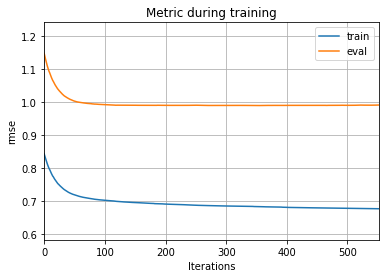

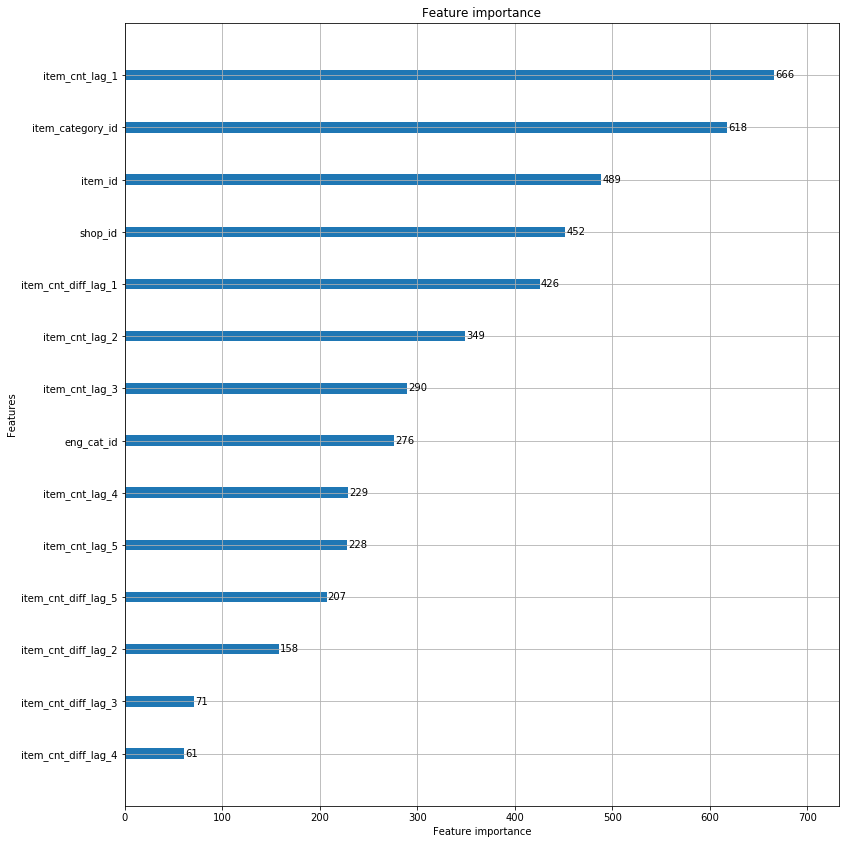

In [23]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
#plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=x_train.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
plt.show()

# Predict with test data¶

In [24]:
pred = ml.predict(model)

In [25]:
# Clip prediction to [0-20]
preds = np.clip(pred,0,20)

In [26]:
data['test'].shape

(214200, 3)

In [27]:
preds.shape

(214200,)

In [28]:
submit = pd.DataFrame({'ID':data['test'].ID,'item_cnt_month': preds })
submit.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.214513
std,61834.358168,0.655010
min,0.000000,0.000000
25%,53549.750000,0.048464
50%,107099.500000,0.070852
75%,160649.250000,0.157409
max,214199.000000,20.000000


In [29]:
pred_submit = pred

In [30]:
print pred.size
print pred
print 'Sum pred:',np.sum(pred)
# pred_submit = pred

# True target values are clipped into [0,20] range.
pred_submit = np.clip(pred_submit,0,20)
    
print pred_submit

214200
[0.48797118 0.06141339 0.8577427  ... 0.02289123 0.03947578 0.02436608]
Sum pred: 45956.00318517714
[0.48797118 0.06141339 0.8577427  ... 0.02289123 0.03947578 0.02436608]


total sales pred: 45948.62198465232 , mean: 0.21451270767811542


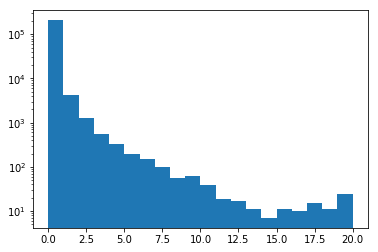

In [31]:
print 'total sales pred:',np.sum(pred_submit), ', mean:',np.mean(pred_submit)
hist_pred = plt.hist(pred_submit,bins=20,log=True)

# Validation with yearly trend

total sales count from Oct21-2018_4 prediction: 45948.62198465232
total sales count from contant 0.5 prediction: 107100.0


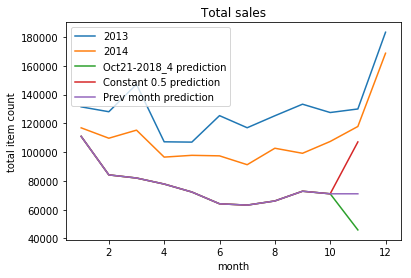

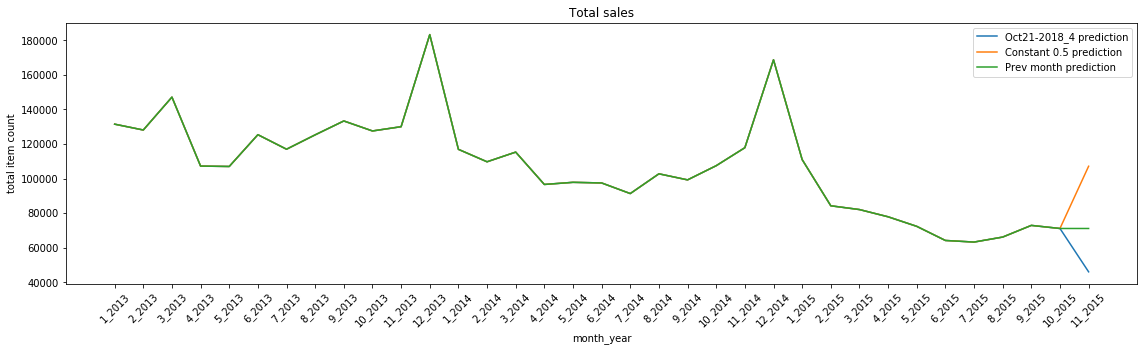

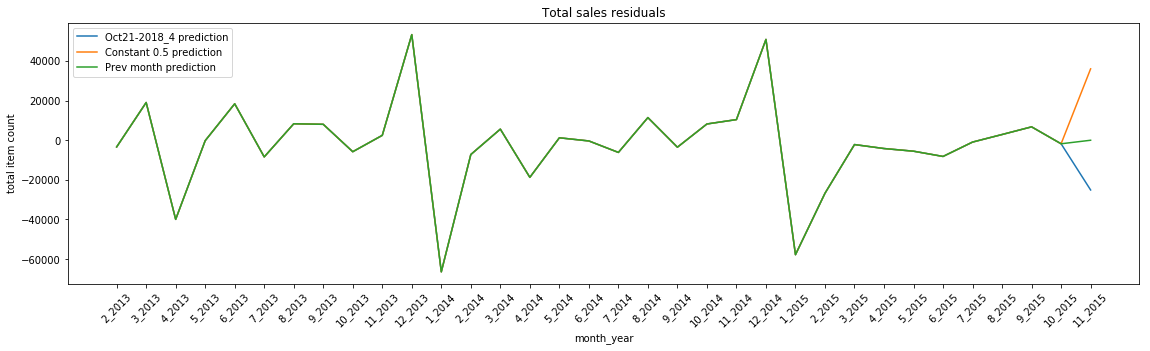

In [32]:
y_test = pd.DataFrame(pred_submit,columns=['item_cnt_month'])

total_item_cnt_2013 = data['sales_2013'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = data['sales_2014'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = data['sales_2015'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

kwargs = {'yearlySales':yearlySales,
        'y_test':y_test,
        'saveName':saveName,
        'saveplots':saveplots,
        'saveFolder':saveFolder}

ut.plotYearly(**kwargs)
ut.plotYearly_v2(**kwargs)
ut.plotResidual(**kwargs)

# Analyse misprediction in validation

In [33]:
#To do

# Prepare submission file

In [34]:
submitName=''
if submitName=='': 
    submitName=saveName
if(createSubmit):
    submit.to_csv(saveFolder+'/'+'submit_'+submitName+'.csv',index=False)